# Model 1
### Project: Exploring Trends in US Happiness with Census Data
Team Members: Taylor Witte, Donald Yu, Praveen Manimaran, Vitush Agarwal, Parker Aman

UCSD Spring 2024 232R Big Data Analytics Using Spark 


## Enviroment Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import logging
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, element_at, udf
from pyspark.sql.functions import explode
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import Row
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import when
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from sklearn.model_selection import train_test_split
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, PCA, PCAModel
from pyspark.sql.types import ArrayType, DoubleType, NumericType
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pylab as pl
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## Import Datasets

### Import World Happiness Data

In [2]:
# Import necessary modules
from pyspark.sql import SparkSession

# Create a SparkSession object
spark = SparkSession.builder \
    .appName("BigDataGroupProject") \
    .config("spark.some.config.option", "some-value") \
    .config("spark.executor.memory", "64g") \
    .config("spark.driver.memory", "64g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [3]:
#World Happiness Data
world_happiness = pd.read_csv("World Happiness Report.csv")

# Filter for USA & years of cencus data
US_happiness =  world_happiness.loc[world_happiness['Country Name'] == 'United States']
US_happiness = US_happiness[US_happiness.Year >= 2012]
US_happiness = US_happiness[US_happiness.Year != 2020]


In [4]:
#World Happiness Results 
happiness_rank = pd.read_csv("World_Happiness_Index.csv"
)

# Filter for USA & years of cencus data
happiness_rank = happiness_rank.loc[happiness_rank['Country'] == 'United States']
happiness_rank = happiness_rank[happiness_rank.Year != 2023]
happiness_rank = happiness_rank[happiness_rank.Year != 2020]
happiness_rank = happiness_rank.rename(columns={'Country': 'Country Name', 'Year':'Year','Index':'Happiness_Index',
                       'Rank':'Happiness_Rank'})
happiness_rank

,Country Name,Year,Happiness_Index,Happiness_Rank
1444,United States,2013,7.082,17
1445,United States,2015,7.119,15
1446,United States,2016,7.104,13
1447,United States,2017,6.993,14
1448,United States,2018,6.886,18
1449,United States,2019,6.892,19
1451,United States,2021,6.951,19
1452,United States,2022,6.977,16
1523,United States,2012,7.270,6


### Import Individual Census Data

In [5]:
#Import Individual Census Data 

# Define the path to the CSV file
file_path = "usa_00006.csv"

 #change this to your own!!

# Read the CSV file into a DataFrame
df_id = spark.read.csv(file_path, header=True, inferSchema=True)

#Normalize Monitary Values to 2000 with CPI99
df_id = df_id.withColumn('AINCTOT', df_id.INCTOT * df_id.CPI99)
df_id = df_id.withColumn('AFTOTINC', df_id.FTOTINC * df_id.CPI99)
df_id = df_id.withColumn('AINCWELFR', df_id.INCWELFR * df_id.CPI99)
df_id = df_id.withColumn('AINCINVST', df_id.INCINVST * df_id.CPI99)
#df_id = df_id.withColumn('APOVERTY', df_id.POVERTY * df_id.CPI99)
#Store raw monetary values
raw_id = df_id.select('SAMPLE', 'CBSERIAL', 'INCTOT', 'FTOTINC', 'INCWELFR', 'INCINVST')
#Remove raw monetary value from dataframe 
df_id = df_id.drop('INCTOT', 'FTOTINC', 'INCWELFR', 'INCINVST')

# Show the schema of the DataFrame
df_id.printSchema()

# Show the first few rows of the DataFrame
df_id.show(5)

root
 |-- YEAR: integer (nullable = true)
 |-- SAMPLE: integer (nullable = true)
 |-- SERIAL: integer (nullable = true)
 |-- CBSERIAL: long (nullable = true)
 |-- HHWT: double (nullable = true)
 |-- CLUSTER: long (nullable = true)
 |-- CPI99: double (nullable = true)
 |-- STRATA: integer (nullable = true)
 |-- GQ: integer (nullable = true)
 |-- PERNUM: integer (nullable = true)
 |-- CBPERNUM: integer (nullable = true)
 |-- PERWT: double (nullable = true)
 |-- FAMSIZE: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- MARST: integer (nullable = true)
 |-- RACE: integer (nullable = true)
 |-- RACED: integer (nullable = true)
 |-- CITIZEN: integer (nullable = true)
 |-- HCOVANY: integer (nullable = true)
 |-- SCHOOL: integer (nullable = true)
 |-- EDUC: integer (nullable = true)
 |-- EDUCD: integer (nullable = true)
 |-- SCHLTYPE: integer (nullable = true)
 |-- EMPSTAT: integer (nullable = true)
 |-- EMPSTATD: integer (nullable = true)


### Import Household Census Data

In [6]:
#Import Household Census Data 

# Define the path to the CSV file
file_path = "usa_00007.csv" #change this to your own!!

# Read the CSV file into a DataFrame
df_hh = spark.read.csv(file_path, header=True, inferSchema=True)

#Since rows represent individuals but we want households remove duplicates
df_hh = df_hh.dropDuplicates()

# Normalize monetary values to 2000 standard with CP199 multiplier
df_hh = df_hh.withColumn('ARENTGRS', df_hh.RENTGRS * df_hh.CPI99)
df_hh = df_hh.withColumn('ACONDOFEE', df_hh.CONDOFEE * df_hh.CPI99)
df_hh = df_hh.withColumn('AMOBLHOME', df_hh.MOBLHOME * df_hh.CPI99)
df_hh = df_hh.withColumn('AHHINCOME', df_hh.HHINCOME * df_hh.CPI99)
df_hh = df_hh.withColumn('AVALUEH', df_hh.VALUEH * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTELEC', df_hh.COSTELEC * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTGAS', df_hh.COSTGAS * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTWATR', df_hh.COSTWATR * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTFUEL', df_hh.COSTFUEL * df_hh.CPI99)

#Store raw monetary values
raw_id = df_hh.select('SAMPLE', 'RENTGRS', 'CONDOFEE', 'MOBLHOME', 'HHINCOME',
                       'VALUEH', 'COSTELEC', 'COSTGAS', 'COSTWATR', 'COSTFUEL')
#Remove raw monetary value from dataframe 
df_hh = df_hh.drop('RENTGRS', 'CONDOFEE', 'MOBLHOME', 'HHINCOME',
                    'VALUEH', 'COSTELEC', 'COSTGAS', 'COSTWATR', 'COSTFUEL')

# Show the schema of the DataFrame
df_hh.printSchema()

# Show the first few rows of the DataFrame
df_hh.show(5)

root
 |-- YEAR: integer (nullable = true)
 |-- SAMPLE: integer (nullable = true)
 |-- SERIAL: integer (nullable = true)
 |-- CBSERIAL: long (nullable = true)
 |-- HHWT: double (nullable = true)
 |-- HHTYPE: integer (nullable = true)
 |-- CLUSTER: long (nullable = true)
 |-- CPI99: double (nullable = true)
 |-- STATEICP: integer (nullable = true)
 |-- MET2023: integer (nullable = true)
 |-- STRATA: integer (nullable = true)
 |-- GQ: integer (nullable = true)
 |-- FARM: integer (nullable = true)
 |-- OWNERSHP: integer (nullable = true)
 |-- OWNERSHPD: integer (nullable = true)
 |-- TAXINCL: integer (nullable = true)
 |-- INSINCL: integer (nullable = true)
 |-- FOODSTMP: integer (nullable = true)
 |-- CINETHH: integer (nullable = true)
 |-- VEHICLES: integer (nullable = true)
 |-- COUPLETYPE: integer (nullable = true)
 |-- NFAMS: integer (nullable = true)
 |-- ARENTGRS: double (nullable = true)
 |-- ACONDOFEE: double (nullable = true)
 |-- AMOBLHOME: double (nullable = true)
 |-- AHHINCOM

### Combine Household and Individual Census Data (Preprocessed)

In [7]:
## Preprocessing for Individual 

#LOOKING: combine not reported and n/a
df_id = df_id.withColumn("LOOKING", when(df_id["LOOKING"] == 3, 0).otherwise(df_id["LOOKING"])) 
#Group Quarters: Combine Household types and Group Quarter Types 
df_id = df_id.withColumn("GQ", when(df_id["GQ"] == 2, 1).when(df_id["GQ"] == 5, 1).when(df_id["GQ"] == 4, 3).otherwise(df_id["GQ"]))

#Remove Varaibles 
var_remove = ['SAMPLE', 'SERIAL', 'HHWT', 'PERNUM', 'CLUSTER', 'CPI99', 'STRATA',
              'PERWT', 'RACED', 'EDUCD', 'EMPSTATD', 'CLASSWKRD']
df_id = df_id.drop(*var_remove)


In [8]:
## Preprocessing for Household 
#Group Quarters: Combine Household types and Group Quarter Types 
df_hh = df_hh.withColumn("GQ", when(df_hh["GQ"] == 2, 1).when(df_hh["GQ"] == 5, 1).when(df_hh["GQ"] == 4, 3).otherwise(df_hh["GQ"]))
#Household Types: combine NA and could not be determined
df_hh = df_hh.withColumn("HHTYPE", when(df_hh["HHTYPE"] == 9, 0).otherwise(df_hh["HHTYPE"]))
#Fix CINETHH None values with Na encoded as 0 
df_hh = df_hh.na.fill(value=0, subset=['CINETHH'])

#Remove Varaibles 
var_remove = ['SAMPLE', 'SERIAL', 'HHWT', 'CLUSTER', 'CPI99', 'STRATA',
              'MET2023', 'TAXINCL', 'INSINCL', 'COUPLETYPE']
df_hh = df_hh.drop(*var_remove)

# Create a new column for all Utilities by combining individual costs of gas, electricity, fuel, and water
# and drop old columns

df_hh = df_hh.withColumn('COSTUTIL', 
                         df_hh['ACOSTELEC'] + df_hh['ACOSTGAS'] + df_hh["ACOSTWATR"] + df_hh['ACOSTFUEL'])

df_hh = df_hh.drop('ACOSTELEC', 'ACOSTGAS', 'ACOSTWATR', 'ACOSTFUEL')

In [9]:
# Test Combining Individual & Household Data 
df_h = df_hh.drop('GQ') #drop duplicate columns 
result_df = df_id.join(df_h, on=["CBSERIAL","YEAR"], how="left")
result_df = result_df.dropDuplicates()
result_df.count()
#result_df.printSchema()
from pyspark.sql.functions import count
result_df.groupBy("YEAR").agg(count("*").alias("count")).show()

+----+-------+
|YEAR|  count|
+----+-------+
|2018|1000701|
|2015|1002140|
|2022|1000453|
|2013|1001492|
|2014|1000578|
|2019| 999725|
|2012| 997299|
|2016| 997981|
|2017|1000345|
|2021| 999712|
+----+-------+



In [10]:
result_df.show(10)

+--------+----+---+--------+-------+---+---+-----+----+-------+-------+------+----+--------+-------+--------+--------+-------+-------+------------------+------------------+---------+----------+------+--------+----+--------+---------+--------+-------+--------+-----+--------+---------+---------+------------------+-----------+---------+
|CBSERIAL|YEAR| GQ|CBPERNUM|FAMSIZE|SEX|AGE|MARST|RACE|CITIZEN|HCOVANY|SCHOOL|EDUC|SCHLTYPE|EMPSTAT|CLASSWKR|UHRSWORK|LOOKING|POVERTY|           AINCTOT|          AFTOTINC|AINCWELFR| AINCINVST|HHTYPE|STATEICP|FARM|OWNERSHP|OWNERSHPD|FOODSTMP|CINETHH|VEHICLES|NFAMS|ARENTGRS|ACONDOFEE|AMOBLHOME|         AHHINCOME|    AVALUEH| COSTUTIL|
+--------+----+---+--------+-------+---+---+-----+----+-------+-------+------+----+--------+-------+--------+--------+-------+-------+------------------+------------------+---------+----------+------+--------+----+--------+---------+--------+-------+--------+-----+--------+---------+---------+------------------+-----------+---

### Individual Normalization

In [11]:
#Recoding 

#LOOKING: combine not reported and n/a
df_idN = df_id.withColumn("LOOKING", when(df_id["LOOKING"] == 3, 0).otherwise(df_id["LOOKING"])) 
#Group Quarters: Combine Household types and Group Quarter Types 
df_idN = df_idN.withColumn("GQ", when(df_idN["GQ"] == 2, 1).when(df_idN["GQ"] == 5, 1).when(df_idN["GQ"] == 4, 3).otherwise(df_idN["GQ"]))

#Remove Varaibles 
var_remove = ['SAMPLE', 'SERIAL', 'CBSERIAL', 'HHWT', 'PERNUM', 'CBPERNUM', 'CLUSTER', 'CPI99', 'STRATA',
              'PERWT', 'RACED', 'EDUCD', 'EMPSTATD', 'CLASSWKRD']
df_idN = df_idN.drop(*var_remove)

#Normalize Columns 
columns = df_idN.columns

# Define UDF to convert vector to array
def vector_to_array(v):
    return v.toArray().tolist()
vector_to_array_udf = udf(vector_to_array, ArrayType(DoubleType()))

# Function to scale a single column
def scale_column(df, input_col):
    assembler = VectorAssembler(inputCols=[input_col], outputCol=f"{input_col}_vec")
    scaler = MinMaxScaler(inputCol=f"{input_col}_vec", outputCol=f"{input_col}_scaled_vec")
    pipeline = Pipeline(stages=[assembler, scaler])
    df = pipeline.fit(df).transform(df)
    df = df.withColumn(f"{input_col}_scaled", vector_to_array_udf(col(f"{input_col}_scaled_vec"))[0])
    df = df.drop(f"{input_col}_vec", f"{input_col}_scaled_vec")
    df = df.drop(input_col).withColumnRenamed(f"{input_col}_scaled", input_col)
    return df

# # Scale each column individually
for col_name in columns:
    if isinstance(df_idN.schema[col_name].dataType, NumericType):
        id_norm = scale_column(df_idN, col_name)

### Household Normalization

In [13]:
#Recoding 
#Group Quarters: Combine Household types and Group Quarter Types 
df_hhN = df_hh.withColumn("GQ", when(df_hh["GQ"] == 2, 1).when(df_hh["GQ"] == 5, 1).when(df_hh["GQ"] == 4, 3).otherwise(df_hh["GQ"]))
#Household Types: combine NA and could not be determined
df_hhN = df_hhN.withColumn("HHTYPE", when(df_hhN["HHTYPE"] == 9, 0).otherwise(df_hhN["HHTYPE"]))
#Fix CINETHH None values with Na encoded as 0 
df_hhN = df_hhN.na.fill(value=0, subset=['CINETHH'])

#Remove Varaibles 
var_remove = ['SAMPLE', 'SERIAL', 'CBSERIAL', 'HHWT', 'CLUSTER', 'CPI99', 'STRATA',
              'MET2023', 'TAXINCL', 'INSINCL', 'COUPLETYPE']
df_hhN = df_hhN.drop(*var_remove)

# Create a new column for all Utilities by combining individual costs of gas, electricity, fuel, and water
# and drop old columns

# Define UDF to convert vector to array
def vector_to_array(v):
    return v.toArray().tolist()
vector_to_array_udf = udf(vector_to_array, ArrayType(DoubleType()))
# Function to scale a single column
def scale_column(df, input_col):
    print(f"Scaling column: {input_col}")
    assembler = VectorAssembler(inputCols=[input_col], outputCol=f"{input_col}_vec")
    scaler = MinMaxScaler(inputCol=f"{input_col}_vec", outputCol=f"{input_col}_scaled_vec")
    pipeline = Pipeline(stages=[assembler, scaler])
    df = pipeline.fit(df).transform(df)
    df = df.withColumn(f"{input_col}_scaled_array", vector_to_array_udf(col(f"{input_col}_scaled_vec")))
    df = df.withColumn(f"{input_col}_scaled", col(f"{input_col}_scaled_array")[0])
    df = df.drop(f"{input_col}_vec", f"{input_col}_scaled_vec", f"{input_col}_scaled_array")
    df = df.drop(input_col).withColumnRenamed(f"{input_col}_scaled", input_col)
    return df
# Scale each column individually if it is numeric
hh_norm = df_hhN
columns = df_hhN.columns
for col_name in columns:
    if isinstance(df_hhN.schema[col_name].dataType, NumericType):
        hh_norm = scale_column(hh_norm, col_name)

Scaling column: YEAR
Scaling column: HHTYPE
Scaling column: STATEICP
Scaling column: GQ
Scaling column: FARM
Scaling column: OWNERSHP
Scaling column: OWNERSHPD
Scaling column: FOODSTMP
Scaling column: CINETHH
Scaling column: VEHICLES
Scaling column: NFAMS
Scaling column: ARENTGRS
Scaling column: ACONDOFEE
Scaling column: AMOBLHOME
Scaling column: AHHINCOME
Scaling column: AVALUEH
Scaling column: COSTUTIL


### Split test/train data

In [14]:
# Split datasets into train and test

id_norm_train, id_norm_test = id_norm.randomSplit(weights=[0.8,0.2], seed=200)
hh_norm_train, hh_norm_test = hh_norm.randomSplit(weights=[0.8,0.2], seed=200)


# Model 1

## Household Census KMeans 

In [15]:
# Create "features" columns for pyspark ML models

hh_norm_columns = hh_norm_train.columns

vecAssembler = VectorAssembler(inputCols=hh_norm_columns, outputCol="features")
new_hh_df = vecAssembler.transform(hh_norm_train)
new_hh_df.cache()

DataFrame[YEAR: double, HHTYPE: double, STATEICP: double, GQ: double, FARM: double, OWNERSHP: double, OWNERSHPD: double, FOODSTMP: double, CINETHH: double, VEHICLES: double, NFAMS: double, ARENTGRS: double, ACONDOFEE: double, AMOBLHOME: double, AHHINCOME: double, AVALUEH: double, COSTUTIL: double, features: vector]

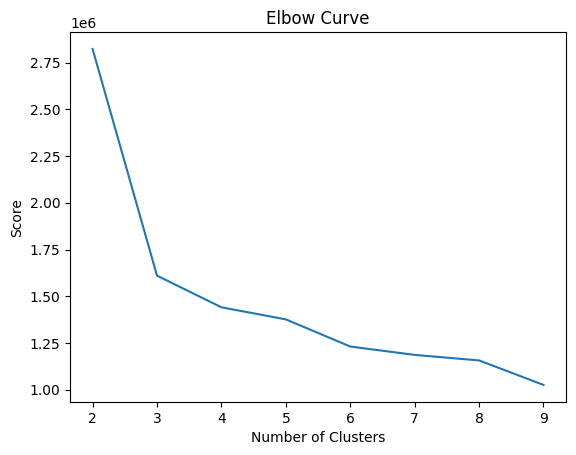

In [16]:
# FInd the best number of k clusters

# Calculate cost and plot
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(new_hh_df)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [17]:
hh_k = 3
hh_kmeans = KMeans().setK(hh_k).setSeed(1).setFeaturesCol('features')
hh_model = hh_kmeans.fit(new_hh_df)

# Get cluster centers
hh_centers = hh_model.clusterCenters()

print("Cluster Centers: ")
for center in hh_centers:
    print(center)

# Add cluster predictions to the dataframe
hh_transformed_df = model.transform(new_hh_df)

# Show some examples of the data with cluster predictions
hh_transformed_df.select("features", "prediction").show(10)

Cluster Centers: 
[0.47582961 0.31128803 0.4021302  0.         0.01618887 0.5
 0.57242113 0.06112318 0.37657197 0.26396562 0.00206897 0.
 0.00624566 0.0023468  0.01085264 0.02830107 0.42008608]
[4.62309735e-01 4.39088110e-01 4.25332480e-01 0.00000000e+00
 4.00992644e-03 9.99984239e-01 9.97021435e-01 2.33569248e-01
 4.26805889e-01 3.27461625e-01 5.79809127e-03 1.26774103e-01
 6.29313191e-08 0.00000000e+00 6.63649747e-03 9.27325176e-01
 5.68558768e-01]
[0.47761017 0.         0.39665999 1.         0.         0.
 0.         0.08900205 0.         0.         0.         0.
 0.         0.         0.92369682 0.92356407 0.        ]
+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|(17,[3,14,15],[1....|         6|
|(17,[3,14,15],[1....|         6|
|(17,[3,14,15],[1....|         6|
|(17,[3,14,15],[1....|         6|
|(17,[3,14,15],[1....|         6|
|(17,[2,3,14,15],[...|         6|
|(17,[2,3,14,15],[...|         6|
|(17,[2,3,14,15],[...|        

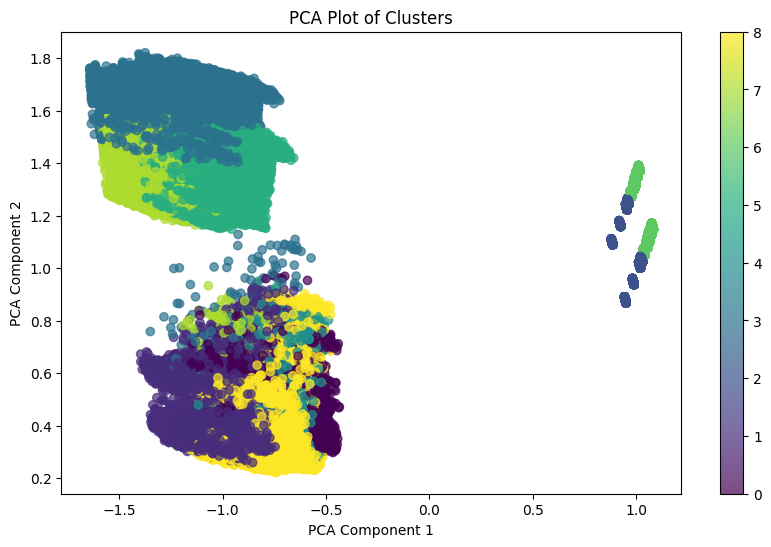

In [18]:
# Perform PCA to reduce dimensionality to 2 components
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(hh_transformed_df)
pca_result = model.transform(hh_transformed_df).select("pcaFeatures", "prediction")

# Collect the PCA result and cluster predictions
pca_result_pd = pca_result.toPandas()
pca_features = np.array(pca_result_pd['pcaFeatures'].tolist())
predictions = pca_result_pd['prediction'].tolist()

# Scatter plot of the PCA result
plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=predictions, cmap='viridis', marker='o', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Plot of Clusters')

plt.colorbar()
plt.show()

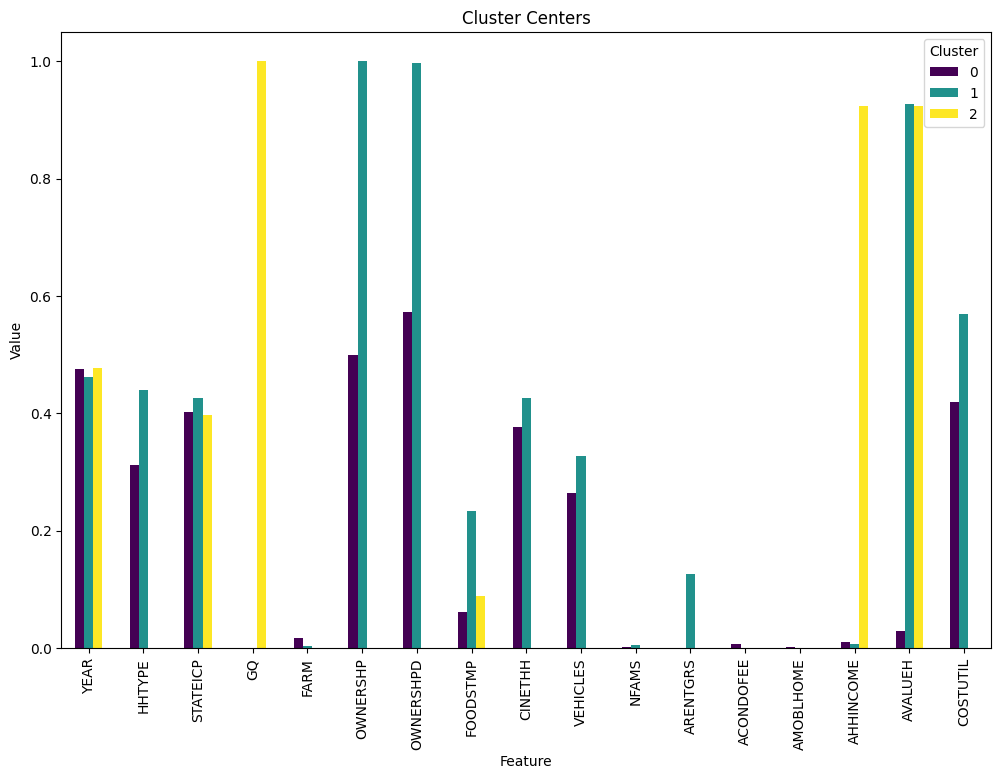

In [19]:
# Get cluster centers

# Convert to a DataFrame for easy plotting
centers_df = pd.DataFrame(hh_centers, columns=hh_norm_columns)
#Export cluster to csv for analysis outside SDSC 
centers_df.to_csv('hh_clusters', index=False)

# Plot cluster centers
centers_df.T.plot(kind='bar', figsize=(12, 8), colormap='viridis')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('Cluster Centers')
plt.legend(title='Cluster')
plt.show()

Cluster 0: Household who own the home 

Cluster 1: Household who Rent 

Cluster 2: Group Quarters
- Household Income is much higher which makes sense considering more people live in a home. 

In [20]:
# Create a ClusteringEvaluator to evaluate clustering by silhouette score
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette')

# Calculate silhouette score
silhouette = evaluator.evaluate(hh_transformed_df)
print(f'Silhouette Score: {silhouette}')

Silhouette Score: 0.35122424918265777


The Cluster Center plots show the average values for each feature for the three clusters identified. Each bar represents a feature and its height reflects the mean value of that feature within the cluster. K-means idenified three clusters: households who own, households who rent and group quarters. 

The silhouette score is 0.351 indicating the clusters are not well-defined and distinct from each other. This may be becuase there are household who are similar for oher metrics between owner and renters. Increasing the groups may allow for more distinct similar groups. 

Based on this analysis K-means may not be a good model for clustering this dataset. Alternatively, pre-selection of features may allow for more distinct clusters. 

## Individual Census KMeans

In [23]:
# Create "features" columns for id_norm_train

id_norm_columns = id_norm_train.columns

vecAssembler_id = VectorAssembler(inputCols=id_norm_columns, outputCol="features")
new_id_df = vecAssembler_id.transform(id_norm_train)
new_id_df.cache()

DataFrame[YEAR: int, GQ: int, FAMSIZE: int, SEX: int, AGE: int, MARST: int, RACE: int, CITIZEN: int, HCOVANY: int, SCHOOL: int, EDUC: int, SCHLTYPE: int, EMPSTAT: int, CLASSWKR: int, UHRSWORK: int, LOOKING: int, POVERTY: int, AINCTOT: double, AFTOTINC: double, AINCWELFR: double, AINCINVST: double, features: vector]

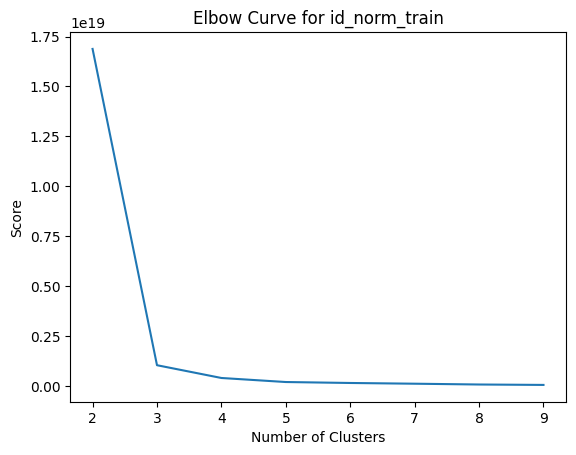

In [25]:
# FInd the best number of k clusters

# Calculate cost and plot for id_norm_train
cost_id = np.zeros(10)
for k in range(2, 10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(new_id_df)
    cost_id[k] = model.summary.trainingCost

# Plot the cost for id_norm_train
df_cost_id = pd.DataFrame(cost_id[2:])
df_cost_id.columns = ["cost"]
new_col_id = [2, 3, 4, 5, 6, 7, 8, 9]
df_cost_id.insert(0, 'cluster', new_col_id)

pl.plot(df_cost_id.cluster, df_cost_id.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve for id_norm_train')
pl.show()

In [26]:
id_k = 3
id_kmeans = KMeans().setK(id_k).setSeed(1).setFeaturesCol('features')
id_model = id_kmeans.fit(new_id_df)

# Get cluster centers
id_centers = id_model.clusterCenters()

print("Cluster Centers: ")
for center in id_centers:
    print(center)

# Add cluster predictions to the dataframe
id_transformed_df = model.transform(new_id_df)

# Show some examples of the data with cluster predictions
id_transformed_df.select("features", "prediction").show(10)

Cluster Centers: 
[2.01672438e+03 1.00000000e+00 2.84280570e+00 1.52180879e+00
 4.87229219e+01 3.00127490e+00 1.85809197e+00 3.48996087e-01
 1.90750479e+00 1.12137525e+00 7.23674918e+00 1.14330547e+00
 1.76953271e+00 1.35590453e+00 2.41060201e+01 4.44868811e-01
 3.34721351e+02 2.85515460e+04 6.31624639e+04 2.88535701e+01
 8.97475847e-03]
[2.01656827e+03 1.00724787e+00 4.55030750e+00 1.48871629e+00
 7.31658938e+00 6.00000000e+00 2.31400642e+00 8.06807221e-02
 1.95113264e+00 1.55830802e+00 9.97313688e-01 1.67369511e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.81332501e+02 6.73897029e+06 1.39942237e+05 6.73890357e+04
 9.28710555e-01]
[2.01677845e+03 3.00000000e+00 1.00000000e+00 1.40752645e+00
 4.19671562e+01 5.25821949e+00 1.95050434e+00 2.19761996e-01
 1.79739710e+00 1.35292958e+00 5.99849934e+00 1.49869907e+00
 2.59625806e+00 9.29844572e-01 1.12450998e+01 3.62004531e-01
 0.00000000e+00 5.81408667e+03 6.70492114e+06 4.88955141e+01
 6.99542095e-03]
+---------------

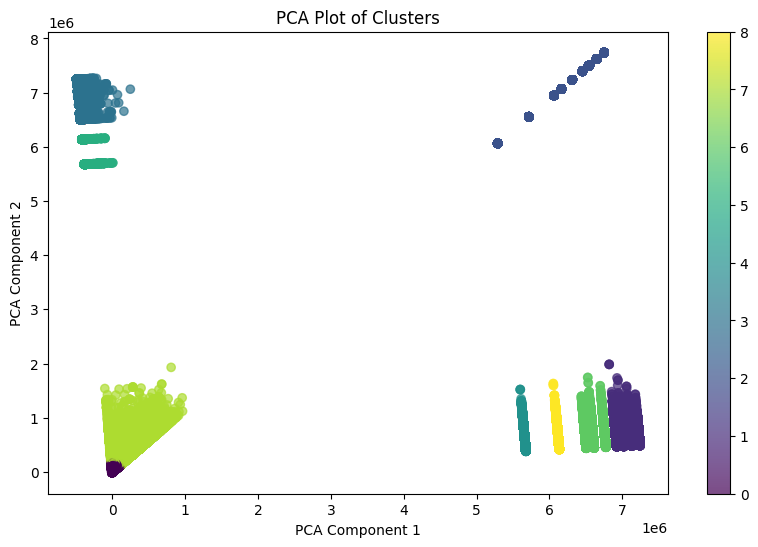

In [27]:
# Perform PCA to reduce dimensionality to 2 components
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(id_transformed_df)
pca_result = model.transform(id_transformed_df).select("pcaFeatures", "prediction")

# Collect the PCA result and cluster predictions
pca_result_pd = pca_result.toPandas()
pca_features = np.array(pca_result_pd['pcaFeatures'].tolist())
predictions = pca_result_pd['prediction'].tolist()

# Scatter plot of the PCA result
plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=predictions, cmap='viridis', marker='o', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Plot of Clusters')

plt.colorbar()
plt.show()

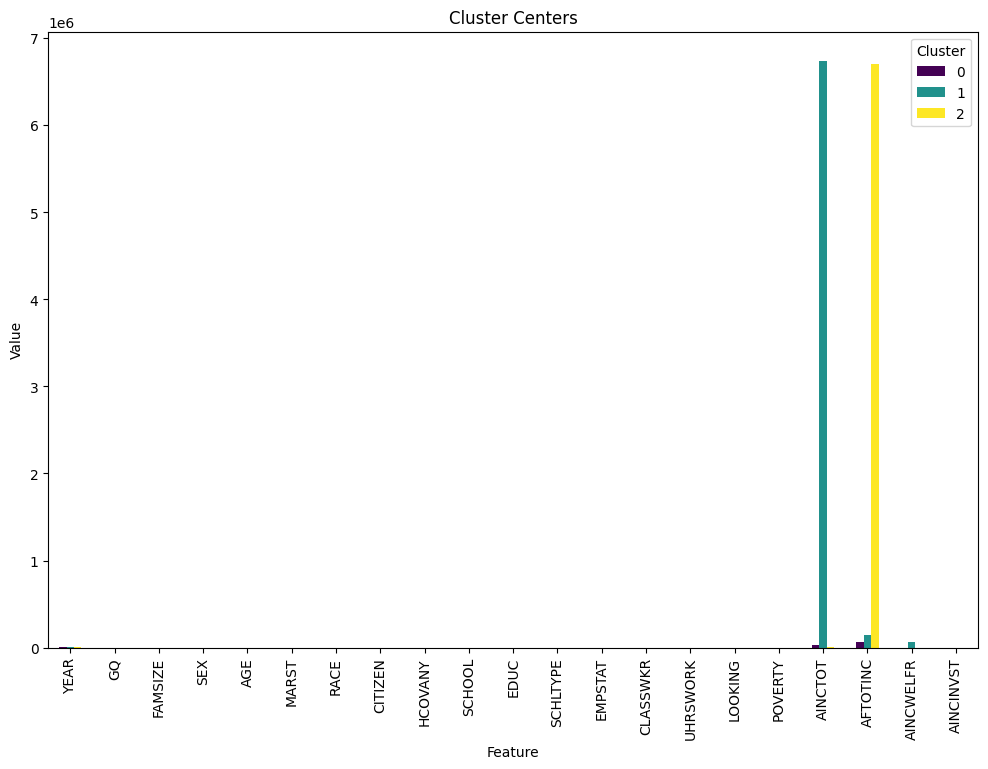

In [28]:
# Get cluster centers

# Convert to a DataFrame for easy plotting
centers_df = pd.DataFrame(id_centers, columns=id_norm_columns)

# Plot cluster centers
centers_df.T.plot(kind='bar', figsize=(12, 8), colormap='viridis')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('Cluster Centers')
plt.legend(title='Cluster')
plt.show()

In [29]:
# Create a ClusteringEvaluator to evaluate clustering by silhouette score
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette')

# Calculate silhouette score
silhouette = evaluator.evaluate(id_transformed_df)
print(f'Silhouette Score: {silhouette}')

Silhouette Score: 0.881478939565164


The Cluster Centers plot shows the average values of each feature for the three identified clusters. Each bar represents a feature, and its height reflects the mean value of that feature within the cluster. The features include demographic, socio-economic, and health-related variables. Notably, variables such as AINCTOT (total income), AFTOTINC (family total income), and POVERTY show significant differences across clusters, indicating that income and poverty status are key distinguishing factors among the clusters.

The silhouette score is 0.869, which is quite high. A high silhouette score close to 1 indicates that the clusters are well-defined and distinct from each other. The points within each cluster are very similar to each other and different from points in other clusters. The clustering model has successfully grouped the data points into clusters that have high internal similarity and low external similarity.

Based on the analysis and visualizations, KMeans appears to be a good model for clustering this dataset. The high silhouette score of 0.869 indicates that the clusters are well-defined and distinct from each other, with data points closer to their assigned cluster centers compared to other clusters. The PCA plot further supports this, showing clear separation between clusters in a two-dimensional space. The cluster centers plot reveals meaningful differences across several features, particularly income-related variables. Together, these findings suggest that KMeans effectively captures the underlying structure of the data, making it a suitable model for identifying and analyzing patterns within the dataset.

## Household Decision Tree

In [30]:
#Split unnormalized data 
hh_train, hh_test = df_hhN.randomSplit(weights=[0.8,0.2], seed=200)

In [31]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [32]:
print(df_hhN.filter((col("OWNERSHP") == 1) & (col("ARENTGRS") > 0)).count())
print(df_hhN.filter((col("OWNERSHP") == 1) & (col("ARENTGRS") == 0)).count())

0
2757352


Adjusted gross rent will be removed since it is not collected for owned homes. 

In [33]:
features = hh_train.columns
features.remove("OWNERSHPD")
features.remove("OWNERSHP")
features.remove('ARENTGRS')

In [34]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(hh_train)
dt_classifier = DecisionTreeClassifier(labelCol="OWNERSHP", featuresCol="features")
model = dt_classifier.fit(data)

In [35]:
#predictions_train = model.transform(data)
test_data = assembler.transform(hh_test)
predictions_test = model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction", metricName="accuracy")

#accuracy_train = evaluator.evaluate(predictions_train)
accuracy_test = evaluator.evaluate(predictions_test)

#print(f"Training Accuracy: {accuracy_train}")
print(f"Test Accuracy: {accuracy_test}")

Test Accuracy: 1.0


In [36]:
feature_importance = model.featureImportances.toArray()

# Show feature importance
for i, column in enumerate(assembler.getInputCols()):
    print(f"Feature '{column}': {feature_importance[i]:.2f}")

Feature 'YEAR': 0.00
Feature 'HHTYPE': 0.00
Feature 'STATEICP': 0.00
Feature 'GQ': 0.29
Feature 'FARM': 0.00
Feature 'FOODSTMP': 0.00
Feature 'CINETHH': 0.00
Feature 'VEHICLES': 0.00
Feature 'NFAMS': 0.00
Feature 'ACONDOFEE': 0.00
Feature 'AMOBLHOME': 0.00
Feature 'AHHINCOME': 0.00
Feature 'AVALUEH': 0.71
Feature 'COSTUTIL': 0.00


In [37]:
# Mapping of features
feature_mapping = {
    0: "YEAR",
    1: "HHTYPE",
    2: "STATEICP",
    3: "GROUP_QUARTERS",
    4: "FARM",
    5: "FOODSTMP",
    6: "CINETHH",
    7: "VEHICLES",
    8: "NFAMS",
    9: "ACONDOFEE",
    10: "AMOBLHOME",
    11: "AHHINCOME",
    12: "HOUSE_VALUE",
    13: "COSTUTIL"
}
# Mapping of predicted class 
class_mapping = {
    0.0: "Na",
    1.0: "Own",
    2.0: "Rent"
}

# replace feature numbers and predicted class numbers with names and labels
def convert_tree_structure(tree_structure):
    lines = tree_structure.split("\n")
    converted_lines = []
    for line in lines:
        for feature_num, feature_name in feature_mapping.items():
            line = line.replace(f"feature {feature_num} ", f"{feature_name} ")
            line = line.replace(f"feature {feature_num}>", f"{feature_name}>")
            line = line.replace(f"feature {feature_num}<=", f"{feature_name}<=")
        for class_num, class_label in class_mapping.items():
            line = line.replace(f"Predict: {class_num}", f"Predict: {class_label}")
        converted_lines.append(line)
    return "\n".join(converted_lines)

tree_structure = model.toDebugString
converted_tree_structure = convert_tree_structure(tree_structure)
print(converted_tree_structure)


DecisionTreeClassificationModel: uid=DecisionTreeClassifier_cc34c7674fb8, depth=2, numNodes=5, numClasses=3, numFeatures=14
  If (HOUSE_VALUE <= 5285725.2155)
   Predict: Own
  Else (HOUSE_VALUE > 5285725.2155)
   If (GROUP_QUARTERS <= 2.0)
    Predict: Rent
   Else (GROUP_QUARTERS > 2.0)
    Predict: Na



In [39]:
rent = hh_test.filter(col("OWNERSHP") == 2).count()
total = hh_test.count()
print("Percent Rented:", (rent/total)*100)
gc = hh_test.filter(col("GQ") > 2).count()
print("Percent Group Quarters:", (gc/total)*100)

Percent Rented: 26.214262128958065
Percent Group Quarters: 10.982955127694218


The decision tree was able to predict with 99% accuracy whether a house was owned or rented based on the four variables. First group quarters were excluded since they are neither rented or owned. Then ownership was predicted based on house value and year.